# Bibliotecas

In [192]:
# ! pip install xgboost

In [193]:
import xgboost as xgb
import pandas as pd
import numpy as np
from sklearn.model_selection import (train_test_split,
                                     cross_val_score)
from sklearn.metrics import (mean_squared_error,
                             r2_score,
                             mean_absolute_error,
                             accuracy_score)
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from math import sqrt
import matplotlib.pyplot as plt

# Dataset

In [194]:
df = sns.load_dataset('mpg')

df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


É um problema regressão, pois a variável *target* 'mpg' é contínua

In [195]:
df = df.drop(['origin', 'name'],  axis=1).copy()

In [196]:
X = df.drop(['mpg'],  axis=1)

y = df['mpg']

In [197]:
X.isnull().sum()

cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model_year      0
dtype: int64

In [198]:
media_horsepower = np.ceil(X['horsepower'].mean())

X.loc[X['horsepower'].isnull(), 'horsepower'] = media_horsepower

In [199]:
X.isnull().sum()

cylinders       0
displacement    0
horsepower      0
weight          0
acceleration    0
model_year      0
dtype: int64

## Split treino e teste

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.3)

# Modelos de regressão

## Sem tunning

In [201]:
# Cross validation apenas para comparação entre modelos
reg_xgboost = xgb.XGBRegressor(objective='reg:squarederror')

resultado_cv_nrmse_xgb = cross_val_score(reg_xgboost, X_train, y_train, scoring='neg_root_mean_squared_error')

print('Negative RMSE: {:.2f}'.format(abs(resultado_cv_nrmse_xgb.mean())))

resultado_cv_rsquared_xgb = cross_val_score(reg_xgboost, X_train, y_train, scoring='r2')

print('R^2: {:.2f}'.format(abs(resultado_cv_rsquared_xgb.mean())))

resultado_cv_nmae_xgb = cross_val_score(reg_xgboost, X_train, y_train, scoring='neg_mean_absolute_error')

print('Negative MAE: {:.2f}'.format(abs(resultado_cv_nmae_xgb.mean())))

Negative RMSE: 2.96
R^2: 0.85
Negative MAE: 2.16


## Tunando o classificador

In [202]:
reg_xgboost_depth = xgb.XGBRegressor(max_depth=2, objective='reg:squarederror') # Altera a altura máxima das árvores

resultado_cv_nrmse_depth = cross_val_score(reg_xgboost, X_train, y_train, scoring='neg_root_mean_squared_error')

print('Negative RMSE: {:.2f}'.format(abs(resultado_cv_nrmse_depth.mean())))

resultado_cv_rsquared_depth = cross_val_score(reg_xgboost, X_train, y_train, scoring='r2')

print('R^2: {:.2f}'.format(abs(resultado_cv_rsquared_depth.mean())))

resultado_cv_nmae_depth = cross_val_score(reg_xgboost, X_train, y_train, scoring='neg_mean_absolute_error')

print('Negative MAE: {:.2f}'.format(abs(resultado_cv_nmae_depth.mean())))

Negative RMSE: 2.96
R^2: 0.85
Negative MAE: 2.16


In [203]:
reg_xgboost_dart = xgb.XGBRegressor(booster='dart', objective='reg:squarederror')

resultado_cv_nrmse_dart = cross_val_score(reg_xgboost, X_train, y_train, scoring='neg_root_mean_squared_error')

print('Negative RMSE: {:.2f}'.format(abs(resultado_cv_nrmse_dart.mean())))

resultado_cv_rsquared_dart = cross_val_score(reg_xgboost, X_train, y_train, scoring='r2')

print('R^2: {:.2f}'.format(abs(resultado_cv_rsquared_dart.mean())))

resultado_cv_nmae_dart = cross_val_score(reg_xgboost, X_train, y_train, scoring='neg_mean_absolute_error')

print('Negative MAE: {:.2f}'.format(abs(resultado_cv_nmae_dart.mean())))

Negative RMSE: 2.96
R^2: 0.85
Negative MAE: 2.16


In [204]:
reg_xgboost_gblinear = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror')

resultado_cv_nrmse_gbl = cross_val_score(reg_xgboost, X_train, y_train, scoring='neg_root_mean_squared_error')

print('Negative RMSE: {:.2f}'.format(abs(resultado_cv_nrmse_gbl.mean())))

resultado_cv_rsquared_gbl = cross_val_score(reg_xgboost, X_train, y_train, scoring='r2')

print('R^2: {:.2f}'.format(abs(resultado_cv_rsquared_gbl.mean())))

resultado_cv_nmae_gbl = cross_val_score(reg_xgboost, X_train, y_train, scoring='neg_mean_absolute_error')

print('Negative MAE: {:.2f}'.format(abs(resultado_cv_nmae_gbl.mean())))

Negative RMSE: 2.96
R^2: 0.85
Negative MAE: 2.16


In [205]:
reg_xgboost_gbtree = xgb.XGBRegressor(booster='gbtree', objective='reg:squarederror')

resultado_cv_nrmse_gbt = cross_val_score(reg_xgboost, X_train, y_train, scoring='neg_root_mean_squared_error')

print('Negative RMSE: {:.2f}'.format(abs(resultado_cv_nrmse_gbt.mean())))

resultado_cv_rsquared_gbt = cross_val_score(reg_xgboost, X_train, y_train, scoring='r2')

print('R^2: {:.2f}'.format(abs(resultado_cv_rsquared_gbt.mean())))

resultado_cv_nmae_gbt = cross_val_score(reg_xgboost, X_train, y_train, scoring='neg_mean_absolute_error')

print('Negative MAE: {:.2f}'.format(abs(resultado_cv_nmae_gbt.mean())))

Negative RMSE: 2.96
R^2: 0.85
Negative MAE: 2.16


# Normalização dos dados

In [206]:
scaler = MinMaxScaler()

X_scaled = scaler.fit_transform(X)

# Principal Component Analysis (PCA)

In [207]:
pca = PCA(n_components=6)

X_scaled_pca = pca.fit_transform(X_scaled)

pca.components_ # Em cada linha é dado os coeficientes de uma componente principal (n_components)
# Coeficientes da combinação das variáveis originais que dão origem às componentes principais

array([[ 0.60110803,  0.48239617,  0.35185088,  0.40957412, -0.17726723,
        -0.28807879],
       [-0.20601297, -0.14236448, -0.03835856, -0.1737575 , -0.0173295 ,
        -0.95148707],
       [ 0.21092234,  0.04934411, -0.34343919,  0.23757095,  0.87691057,
        -0.09856141],
       [ 0.65357171, -0.06281401, -0.45548016, -0.57450958, -0.17704103,
        -0.00560893],
       [ 0.21166047, -0.27591536,  0.74084626, -0.43270892,  0.37623776,
         0.03775601],
       [-0.28245959,  0.81517885,  0.02153467, -0.47782753,  0.16249769,
         0.02261922]])

In [208]:
pca.explained_variance_ratio_.round(3)

array([0.72 , 0.189, 0.053, 0.024, 0.008, 0.007])

* A primeira componente principal explica 72% da variabilidade dos dados
* A segunda componente principal explica 18,9% da variabilidade dos dados

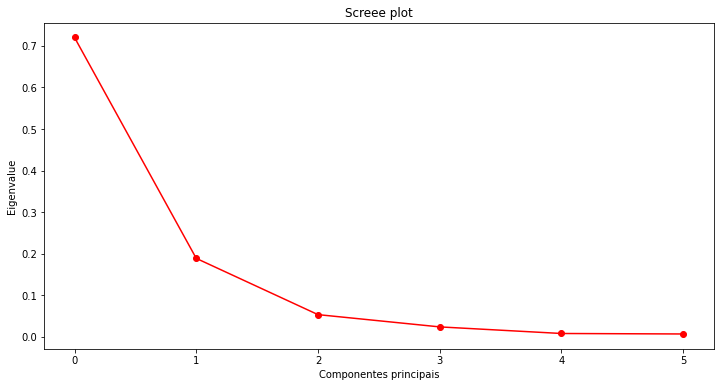

In [209]:
fig = plt.figure(figsize=(12, 6))

plt.plot(pca.explained_variance_ratio_, 'ro-')
plt.title('Screee plot')
plt.xlabel('Componentes principais')
plt.ylabel('Eigenvalue')

plt.show()

In [210]:
pca = PCA(n_components=2)

X_scaled_pca_two_comp = pca.fit_transform(X_scaled)

pca_componentes = pca.components_.round(3)

index = ('cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year')

columns = ('cp1', 'cp2')

data = pca_componentes.transpose()

df_componentes = pd.DataFrame(data=data, index=index, columns=columns)

df_componentes # Correlação entre as variáveis e as componentes principais

,cp1,cp2
cylinders,0.601,-0.206
displacement,0.482,-0.142
horsepower,0.352,-0.038
weight,0.410,-0.174
acceleration,-0.177,-0.017
model_year,-0.288,-0.951


In [211]:
pca_1 = pca.transform(X)[:, 0]

pca_2 = pca.transform(X)[:, 1]

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [212]:
df_scaled = pd.DataFrame(data=X_scaled_pca_two_comp, columns=['cp1', 'cp2'])

df_scaled

,cp1,cp2
0,0.740258,0.301964
1,0.888009,0.270054
2,0.794869,0.298129
3,0.766518,0.302396
4,0.762588,0.305975
...,...,...
393,-0.441910,-0.382645
394,-0.732133,-0.336507
395,-0.467243,-0.351876
396,-0.531042,-0.368794


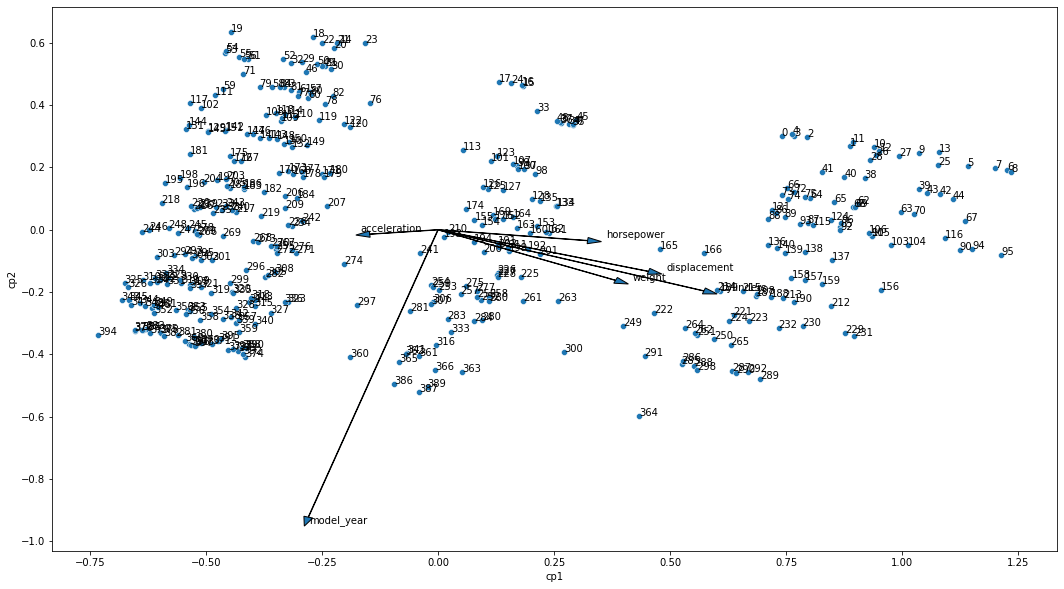

In [213]:
ax = sns.scatterplot(data=df_scaled, x='cp1', y='cp2', palette='Accent')

ax.figure.set_size_inches(18, 10)

for k, v in df_scaled.iterrows():
    ax.annotate(k, v)


for i in range(0, len(df_componentes)):
    plt.arrow(0, 0, df_componentes.iloc[i][0], df_componentes.iloc[i][1], head_width = 0.02, length_includes_head=True)

    ax.annotate(df_componentes.index[i], xy=(df_componentes.iloc[i][0] + 0.01, df_componentes.iloc[i][1] + 0.01))

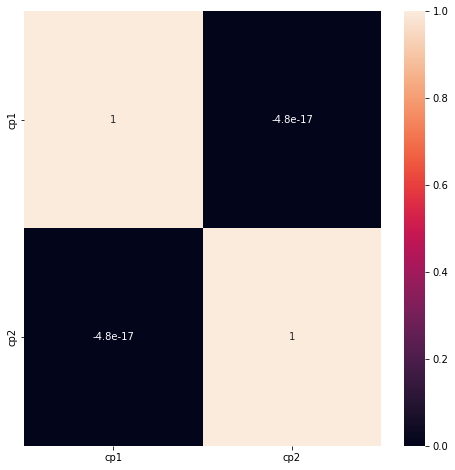

In [214]:
ax = sns.heatmap(df_scaled.corr(), annot=True)

ax.figure.set_size_inches(8, 8)

## Split treino e teste

In [215]:
X_train_new, X_test_new, y_train, y_test = train_test_split(X_scaled_pca_two_comp, y, random_state=0, test_size=0.3)

# Modelos de regressão

In [216]:
# Cross validation apenas para comparação entre modelos
reg_xgboost_pca = xgb.XGBRegressor(objective='reg:squarederror')

resultado_cv_nrmse_xgb_pca = cross_val_score(reg_xgboost_pca, X_train_new, y_train, scoring='neg_root_mean_squared_error')

print('Negative RMSE: {:.2f}'.format(abs(resultado_cv_nrmse_xgb_pca.mean())))

resultado_cv_rsquared_xgb_pca = cross_val_score(reg_xgboost_pca, X_train_new, y_train, scoring='r2')

print('R^2: {:.2f}'.format(abs(resultado_cv_rsquared_xgb_pca.mean())))

resultado_cv_nmae_xgb_pca = cross_val_score(reg_xgboost_pca, X_train_new, y_train, scoring='neg_mean_absolute_error')

print('Negative MAE: {:.2f}'.format(abs(resultado_cv_nmae_xgb_pca.mean())))

Negative RMSE: 3.15
R^2: 0.83
Negative MAE: 2.35


## Tunando o classificador

In [217]:
reg_xgboost_depth_pca = xgb.XGBRegressor(max_depth=2, objective='reg:squarederror') # Altera a altura máxima das árvores

resultado_cv_nrmse_depth_pca = cross_val_score(reg_xgboost_depth_pca, X_train_new, y_train, scoring='neg_root_mean_squared_error')

print('Negative RMSE: {:.2f}'.format(abs(resultado_cv_nrmse_depth_pca.mean())))

resultado_cv_rsquared_depth_pca = cross_val_score(reg_xgboost_depth_pca, X_train_new, y_train, scoring='r2')

print('R^2: {:.2f}'.format(abs(resultado_cv_rsquared_depth_pca.mean())))

resultado_cv_nmae_depth_pca = cross_val_score(reg_xgboost_depth_pca, X_train_new, y_train, scoring='neg_mean_absolute_error')

print('Negative MAE: {:.2f}'.format(abs(resultado_cv_nmae_depth_pca.mean())))

Negative RMSE: 3.04
R^2: 0.84
Negative MAE: 2.25


In [218]:
reg_xgboost_dart_pca = xgb.XGBRegressor(booster='dart', objective='reg:squarederror')

resultado_cv_nrmse_dart_pca = cross_val_score(reg_xgboost_dart_pca, X_train_new, y_train, scoring='neg_root_mean_squared_error')

print('Negative RMSE: {:.2f}'.format(abs(resultado_cv_nrmse_dart_pca.mean())))

resultado_cv_rsquared_dart_pca = cross_val_score(reg_xgboost_dart_pca, X_train_new, y_train, scoring='r2')

print('R^2: {:.2f}'.format(abs(resultado_cv_rsquared_dart_pca.mean())))

resultado_cv_nmae_dart_pca = cross_val_score(reg_xgboost_dart_pca, X_train_new, y_train, scoring='neg_mean_absolute_error')

print('Negative MAE: {:.2f}'.format(abs(resultado_cv_nmae_dart_pca.mean())))

Negative RMSE: 3.15
R^2: 0.83
Negative MAE: 2.35


In [219]:
reg_xgboost_gblinear_pca = xgb.XGBRegressor(booster='gblinear', objective='reg:squarederror')

resultado_cv_nrmse_gbl_pca = cross_val_score(reg_xgboost_gblinear_pca, X_train_new, y_train, scoring='neg_root_mean_squared_error')

print('Negative RMSE: {:.2f}'.format(abs(resultado_cv_nrmse_gbl_pca.mean())))

resultado_cv_rsquared_gbl_pca = cross_val_score(reg_xgboost_gblinear_pca, X_train_new, y_train, scoring='r2')

print('R^2: {:.2f}'.format(abs(resultado_cv_rsquared_gbl_pca.mean())))

resultado_cv_nmae_gbl_pca = cross_val_score(reg_xgboost_gblinear_pca, X_train_new, y_train, scoring='neg_mean_absolute_error')

print('Negative MAE: {:.2f}'.format(abs(resultado_cv_nmae_gbl_pca.mean())))

Negative RMSE: 6.49
R^2: 0.29
Negative MAE: 5.39


In [220]:
reg_xgboost_gbtree_pca = xgb.XGBRegressor(booster='gbtree', objective='reg:squarederror')

resultado_cv_nrmse_gbt_pca = cross_val_score(reg_xgboost_gbtree_pca, X_train_new, y_train, scoring='neg_root_mean_squared_error')

print('Negative RMSE: {:.2f}'.format(abs(resultado_cv_nrmse_gbt_pca.mean())))

resultado_cv_rsquared_gbt_pca = cross_val_score(reg_xgboost_gbtree_pca, X_train_new, y_train, scoring='r2')

print('R^2: {:.2f}'.format(abs(resultado_cv_rsquared_gbt_pca.mean())))

resultado_cv_nmae_gbt_pca = cross_val_score(reg_xgboost_gbtree_pca, X_train_new, y_train, scoring='neg_mean_absolute_error')

print('Negative MAE: {:.2f}'.format(abs(resultado_cv_nmae_gbt_pca.mean())))

Negative RMSE: 3.15
R^2: 0.83
Negative MAE: 2.35


# Análise dos resultados

In [221]:
data = ((resultado_cv_nrmse_xgb.mean().round(3),
        resultado_cv_rsquared_xgb.mean().round(3),
        resultado_cv_nmae_xgb.mean().round(3)),
        (resultado_cv_nrmse_depth.mean().round(3),
        resultado_cv_rsquared_depth.mean().round(3),
        resultado_cv_nmae_depth.mean().round(3)),
        (resultado_cv_nrmse_dart.mean().round(3),
        resultado_cv_rsquared_dart.mean().round(3),
        resultado_cv_nmae_dart.mean().round(3)),
        (resultado_cv_nrmse_gbl.mean().round(3),
        resultado_cv_rsquared_gbl.mean().round(3),
        resultado_cv_nmae_gbl.mean().round(3)),
        (resultado_cv_nrmse_gbt.mean().round(3),
        resultado_cv_rsquared_gbt.mean().round(3),
        resultado_cv_nmae_gbt.mean().round(3)),
        (resultado_cv_nrmse_xgb_pca.mean().round(3),
        resultado_cv_rsquared_xgb_pca.mean().round(3),
        resultado_cv_nmae_xgb_pca.mean().round(3)),
        (resultado_cv_nrmse_depth_pca.mean().round(3),
        resultado_cv_rsquared_depth_pca.mean().round(3),
        resultado_cv_nmae_depth_pca.mean().round(3)),
        (resultado_cv_nrmse_dart_pca.mean().round(3),
        resultado_cv_rsquared_dart_pca.mean().round(3),
        resultado_cv_nmae_dart_pca.mean().round(3)),
        (resultado_cv_nrmse_gbl_pca.mean().round(3),
        resultado_cv_rsquared_gbl_pca.mean().round(3),
        resultado_cv_nmae_gbl_pca.mean().round(3)),
        (resultado_cv_nrmse_gbt_pca.mean().round(3),
        resultado_cv_rsquared_gbt_pca.mean().round(3),
        resultado_cv_nmae_gbt_pca.mean().round(3)))


columns = ('negative_rmse',
           'r^2',
           'negative_mae')


index = ('reg_xgboost',
         'reg_xgboost_depth',
         'reg_xgboost_dart',
         'reg_xgboost_gblinear',
         'reg_xgboost_gbtree',
         'reg_xgboost_pca',
         'reg_xgboost_depth_pca',
         'reg_xgboost_dart_pca',
         'reg_xgboost_gblinear_pca',
         'reg_xgboost_gbtree_pca')



df_results = pd.DataFrame(data=data, columns=columns, index=index)

In [222]:
df_results.sort_values(['negative_rmse', 'negative_mae'], ascending=False)

,negative_rmse,r^2,negative_mae
reg_xgboost,-2.955,0.852,-2.156
reg_xgboost_depth,-2.955,0.852,-2.156
reg_xgboost_dart,-2.955,0.852,-2.156
reg_xgboost_gblinear,-2.955,0.852,-2.156
reg_xgboost_gbtree,-2.955,0.852,-2.156
reg_xgboost_depth_pca,-3.044,0.839,-2.251
reg_xgboost_pca,-3.153,0.825,-2.348
reg_xgboost_dart_pca,-3.153,0.825,-2.348
reg_xgboost_gbtree_pca,-3.153,0.825,-2.348
reg_xgboost_gblinear_pca,-6.492,0.290,-5.388


# Aplicação do melhor modelo

In [223]:
melhor_modelo = reg_xgboost

melhor_modelo.fit(X_train, y_train)

XGBRegressor(objective='reg:squarederror')

In [224]:
y_pred = melhor_modelo.predict(X_test)

## Acurácia

### Cross validation

In [225]:
resultado_cv_nrmse = cross_val_score(melhor_modelo, X_train_new, y_train, scoring='neg_root_mean_squared_error')

print('Negative RMSE: {:.2f}'.format(resultado_cv_nrmse.mean()))

resultado_cv_rsquared = cross_val_score(melhor_modelo, X_train_new, y_train, scoring='r2')

print('R^2: {:.2f}'.format(resultado_cv_rsquared.mean()))

resultado_cv_nmae = cross_val_score(melhor_modelo, X_train_new, y_train, scoring='neg_mean_absolute_error')

print('Negative MAE: {:.2f}'.format(resultado_cv_nmae.mean()))

Negative RMSE: -3.15
R^2: 0.83
Negative MAE: -2.35


In [226]:
y_pred_all = melhor_modelo.predict(X)

# Uso do neg para buscar o erro "quanto menor, melhor"
# Caso contrário, o scikit-learn vai maximizar o erro, trazendo o maior valor, neste caso "quanto maior, pior", o que é indesejado

df['mpg_pred'] = y_pred_all

df['mpg_pred'] = df['mpg_pred'].round(2)

resultado_cv_rmse = sqrt(mean_squared_error(y, y_pred_all))

print('RMSE: {:.2f}'.format(resultado_cv_rmse))

resultado_cv_rsquared = r2_score(y, y_pred_all)

print('R^2: {:.2f}'.format(resultado_cv_rsquared))

resultado_cv_mae = mean_absolute_error(y, y_pred_all)

print('Negative MAE: {:.2f}'.format(resultado_cv_mae.mean()))

RMSE: 1.98
R^2: 0.94
Negative MAE: 1.39


# Conversões de unidades

In [227]:
mpg_para_kml = 0.425144

df['km_l'] = round(df['mpg'] * mpg_para_kml, 2)

df['km_l_pred'] = round(df['mpg_pred'] * mpg_para_kml, 2)


libras_para_kg = 0.453592

df['kg'] = round(df['weight'] * libras_para_kg, 2)

In [228]:
reorder_columns = ['mpg',
                   'km_l',
                   'mpg_pred',
                   'km_l_pred',
                   'cylinders',
                   'displacement',
                   'horsepower',
                   'weight',
                   'kg',
                   'acceleration',
                   'model_year']

df = df.reindex(columns=reorder_columns, copy=True)

df

,mpg,km_l,mpg_pred,km_l_pred,cylinders,displacement,horsepower,weight,kg,acceleration,model_year
0,18.0,7.65,16.320000,6.940000,8,307.0,130.0,3504,1589.39,12.0,70
1,15.0,6.38,15.580000,6.620000,8,350.0,165.0,3693,1675.12,11.5,70
2,18.0,7.65,16.150000,6.870000,8,318.0,150.0,3436,1558.54,11.0,70
3,16.0,6.80,15.720000,6.680000,8,304.0,150.0,3433,1557.18,12.0,70
4,17.0,7.23,16.180000,6.880000,8,302.0,140.0,3449,1564.44,10.5,70
...,...,...,...,...,...,...,...,...,...,...,...
393,27.0,11.48,26.809999,11.400000,4,140.0,86.0,2790,1265.52,15.6,82
394,44.0,18.71,43.419998,18.459999,4,97.0,52.0,2130,966.15,24.6,82
395,32.0,13.60,32.540001,13.830000,4,135.0,84.0,2295,1040.99,11.6,82
396,28.0,11.90,29.670000,12.610000,4,120.0,79.0,2625,1190.68,18.6,82


# Análise gráfica

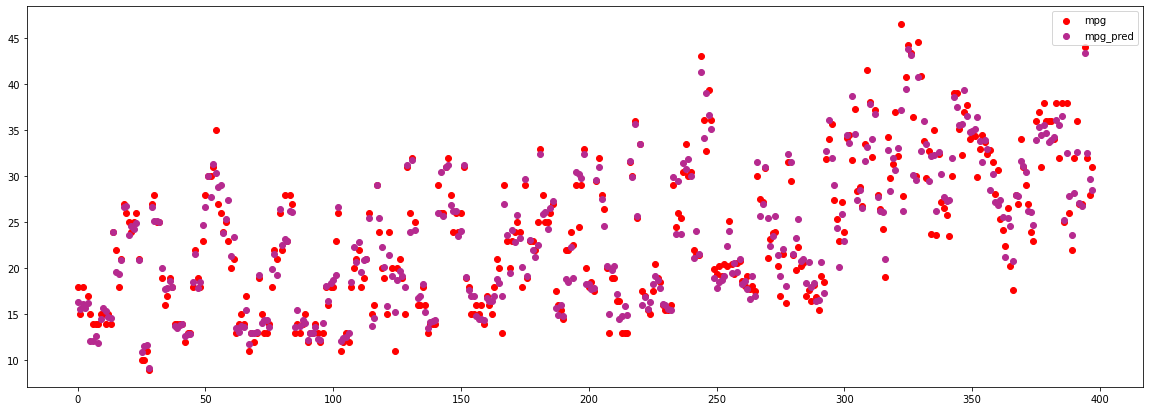

In [229]:
plt.figure(figsize=(20, 7))

plt.scatter(y=df['mpg'], x=df.index, color='#FF0000', label='mpg')
plt.scatter(y=df['mpg_pred'], x=df.index, color='#B62A8F', label='mpg_pred')

plt.legend()

# Previsão de mpg

In [230]:
# Variáveis com valores randômicos

cylinders = np.random.randint(df['cylinders'].min(), df['cylinders'].max() + 1)

displacement = np.random.randint(df['displacement'].min(), df['displacement'].max() + 1)

horsepower = np.random.randint(df['horsepower'].min(), df['horsepower'].max() + 1)

weight = np.random.randint(df['kg'].min(), df['kg'].max() + 1)

acceleration = np.random.randint(df['acceleration'].min(), df['acceleration'].max() + 1)

model_year = np.random.randint(df['model_year'].min(), df['model_year'].max() + 1)


dados_pred = {'cylinders': cylinders,
                 'displacement': displacement,
                 'horsepower': horsepower,
                 'weight': weight,
                 'acceleration': acceleration,
                 'model_year': model_year}


df_pred = pd.DataFrame(dados_pred, dtype='float64', index=[0])

y_user_pred = melhor_modelo.predict(df_pred).round(2)

df_pred['mpg_pred'] = y_user_pred

df_pred

,cylinders,displacement,horsepower,weight,acceleration,model_year,mpg_pred
0,3.0,362.0,147.0,2212.0,16.0,79.0,27.33
